# Решение задачи кредитного скоринга

Ссылка на датасет: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data


# 1. Анализ датасета

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [116]:
df = pd.read_csv('loan_data.csv')

In [117]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [118]:
df.isnull().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


Нет null признаков в датасете

In [119]:
df.groupby('loan_status').describe()

person_age                                                      \
                 count       mean       std   min   25%   50%   75%    max   
loan_status                                                                  
0              35000.0  27.833571  6.073367  20.0  24.0  26.0  30.0  144.0   
1              10000.0  27.521300  5.939063  20.0  23.0  26.0  30.0   70.0   

            person_income                ... cb_person_cred_hist_length        \
                    count          mean  ...                        75%   max   
loan_status                              ...                                    
0                 35000.0  86157.040743  ...                        8.0  30.0   
1                 10000.0  59886.096900  ...                        8.0  30.0   

            credit_score                                                     \
                   count        mean        std    min    25%    50%    75%   
loan_status                                                                   
0                35000.0  632.814914  50.475294  390.0  602.0  640.0  670.0   
1                10000.0  631.887200  50.293485  431.0  601.0  639.0  669.0   

                    
               max  
loan_status         
0            850.0  
1            767.0  

[2 rows x 64 columns]

10 000, кому выдали кредит

35 000, кому не выдали


# 2. Предобработка данных

In [120]:
df.duplicated().sum()


np.int64(0)

Нет дубликатов

In [121]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [122]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int', 'float']).columns.tolist()

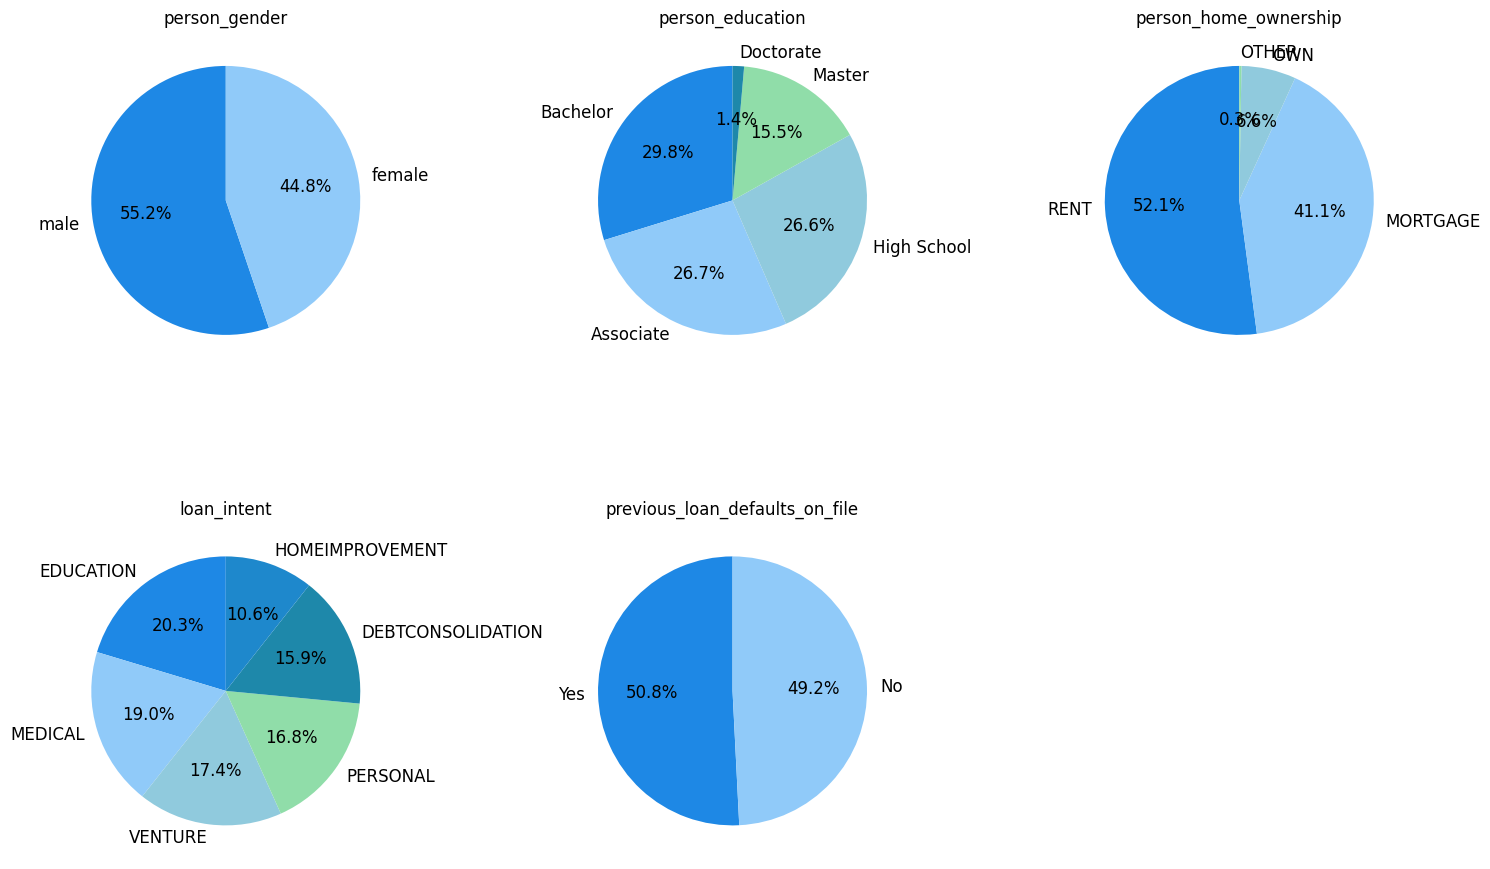

In [123]:
colors = ['#1E88E5', '#90CAF9', '#90CADD', '#90DDA9', '#1E88AA', '#1E88CC', '#90CADD', '#90FFDD']

cols = 3
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    df[feature].value_counts().plot(
        kind='pie',
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 12},
        ax=axes[i]
    )
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('')

for j in range(len(categorical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

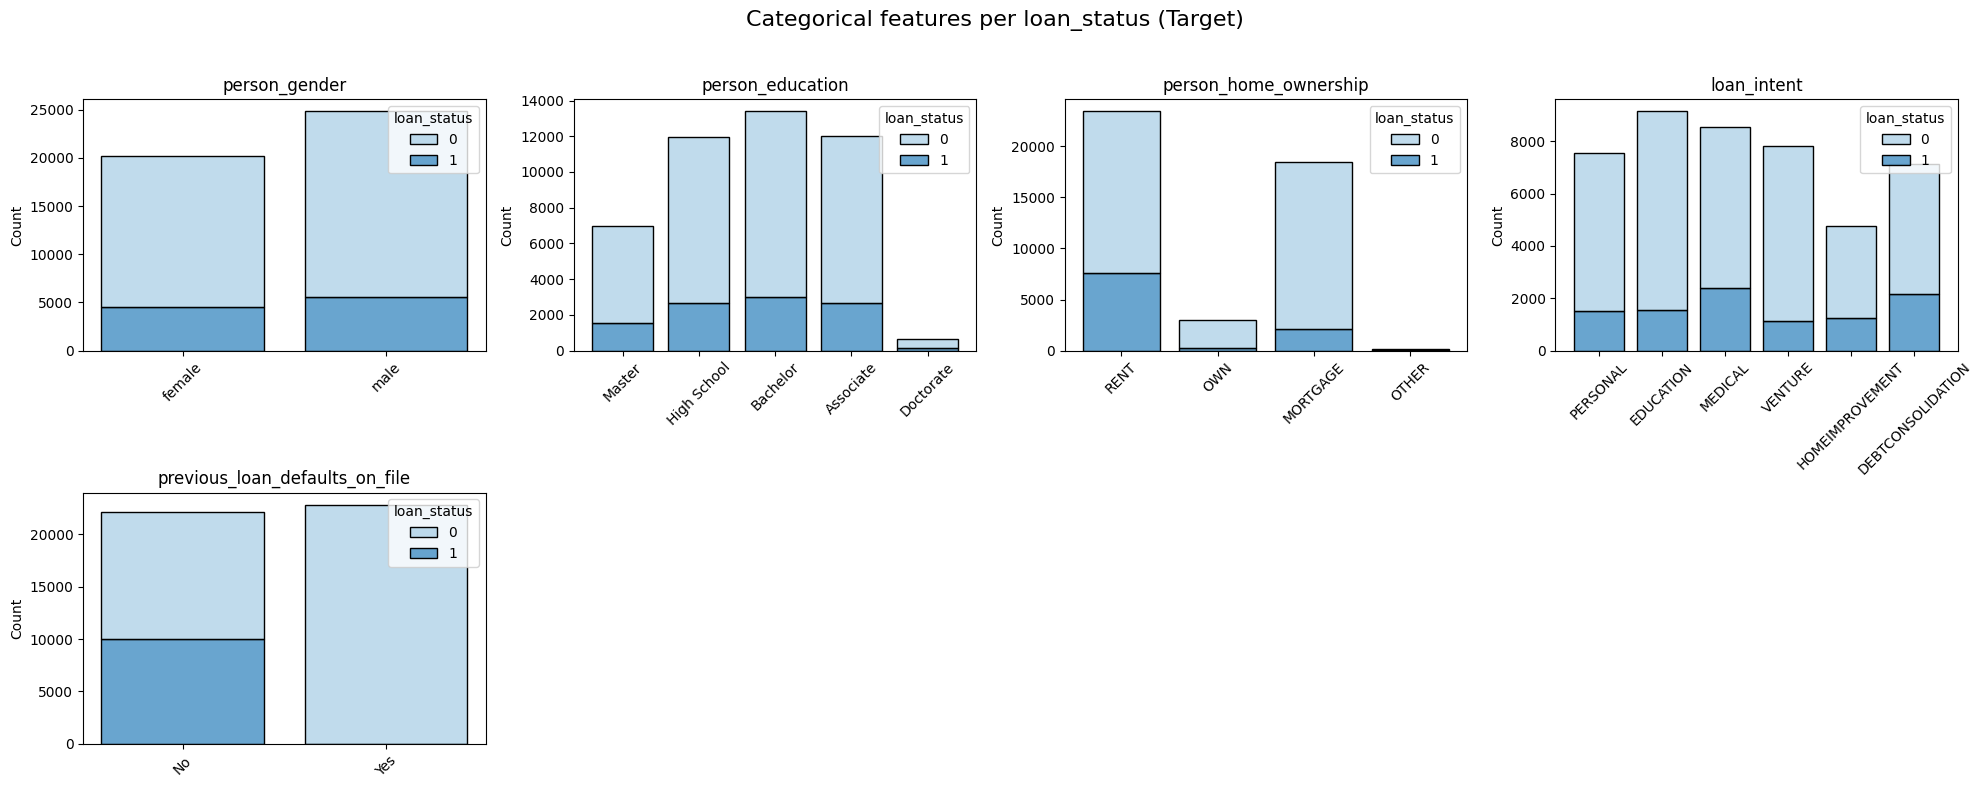

In [124]:

cols = 4
rows = -(-len(categorical_features) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.histplot(
        data=df,
        x=feature,
        hue='loan_status',
        multiple='stack',
        palette='Blues',
        ax=axes[i],
        shrink=0.8
    )
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Categorical features per loan_status (Target)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

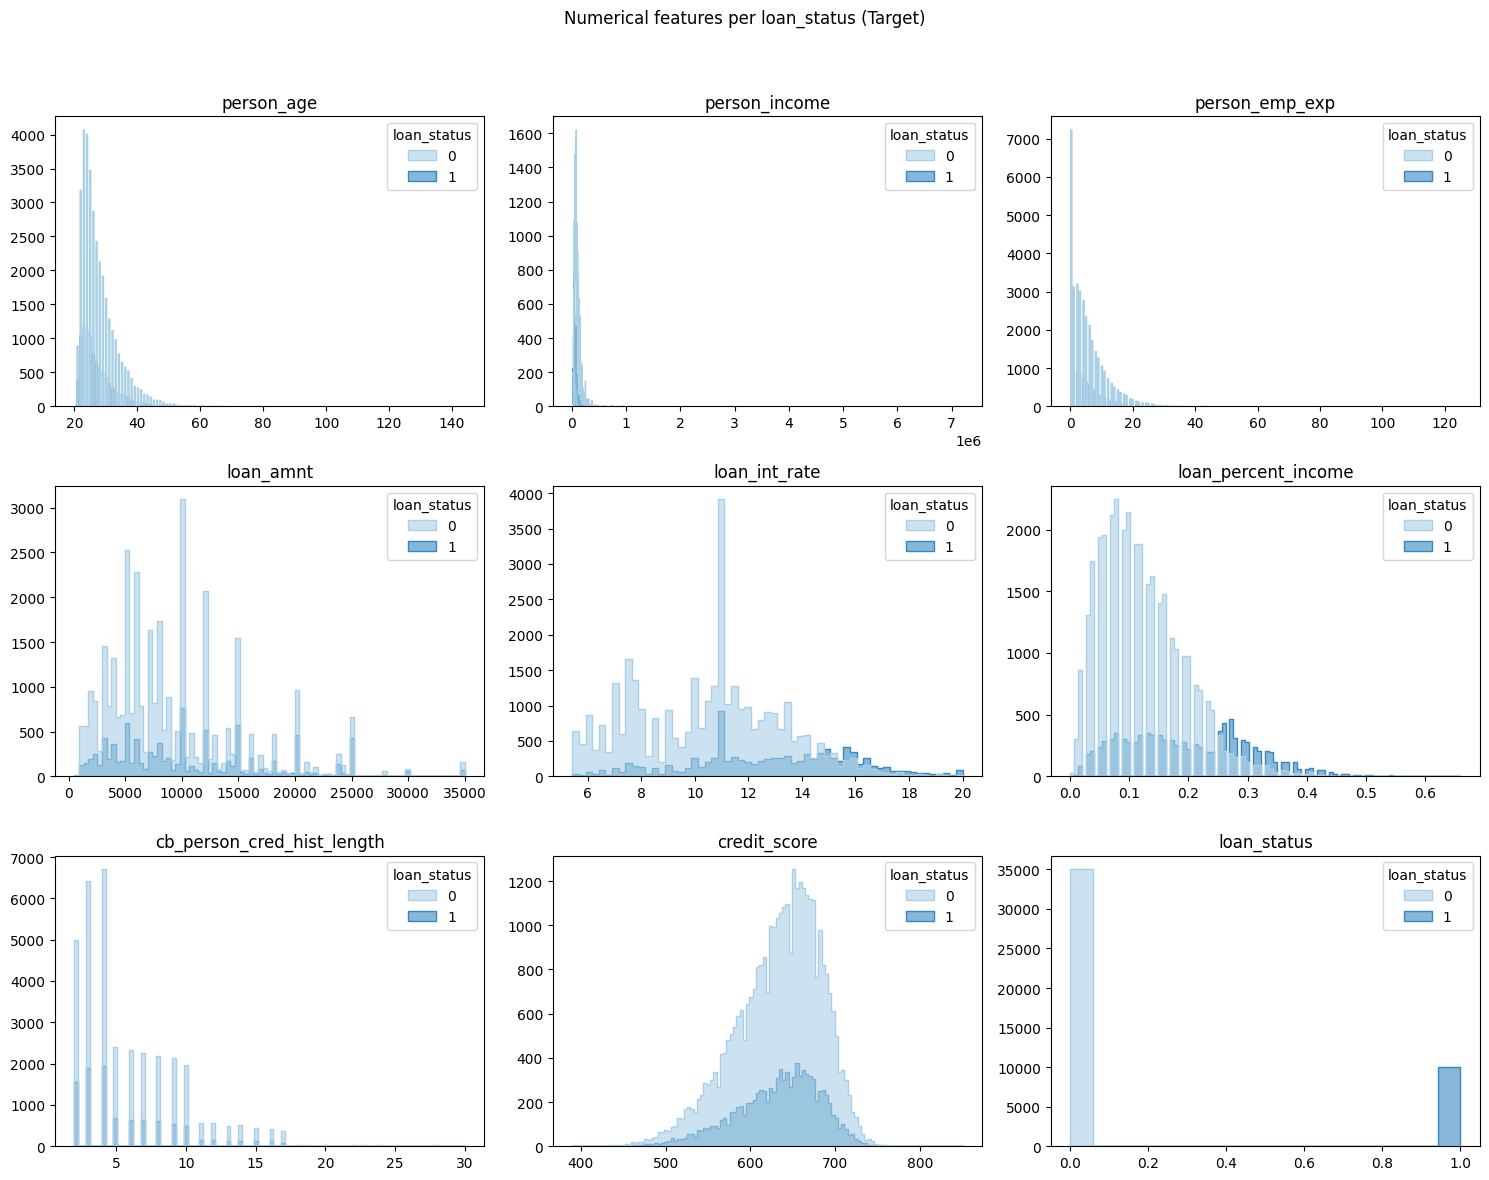

In [125]:
cols = 3
rows = -(-len(numerical_features) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(
        data=df,
        x=feature,
        hue='loan_status',
        palette='Blues',
        element='step',
        stat='count',
        common_norm=False,
        alpha=0.6,
        ax=axes[i]
    )
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Numerical features per loan_status (Target)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Заметим, что loan_percent_income линейно зависит от loan_amount и от person_income

In [126]:
df = df.drop(columns=['loan_percent_income'])

Разобьем данные на обучающую и тестовую выборки

In [127]:
y = df['loan_status'].astype(int)
X = df.drop(columns=['loan_status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [128]:
num_cols  = X.select_dtypes(include=['number']).columns.tolist()
cat_cols  = X.select_dtypes(include=['object','category','bool']).columns.tolist()


In [129]:
num_tf = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_tf = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

preprocessor = ColumnTransformer(transformers=[('num', num_tf, num_cols), ('cat', cat_tf, cat_cols)])

# 3. Бейзлайн -  логистическая регрессия


In [130]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced')

pipe = make_pipeline(preprocessor, logreg)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length',
                                                   'credit_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [131]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

proba = pipe.predict_proba(X_test)[:,1]

print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9466105714285715
PR-AUC: 0.8334403827034027


Результаты получились неплохие, достаточно высокие показатели у ROC-AUC и PR-AUC кривых

In [132]:
pred  = (proba >= 0.9).astype(int)
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.855     0.987     0.916      7000
           1      0.899     0.416     0.569      2000

    accuracy                          0.860      9000
   macro avg      0.877     0.701     0.743      9000
weighted avg      0.865     0.860     0.839      9000



Значение proba можно менять, это зависит от того, значение precision или recall нам важнее

Визуализируем значения весов у модели:

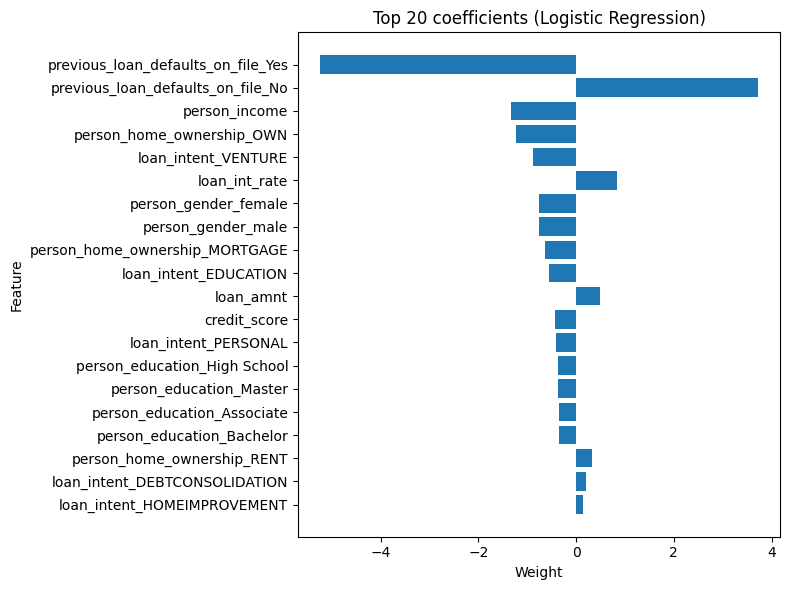

In [133]:
ohe = pipe.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehotencoder']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, cat_names]

coefs = pipe.named_steps['logisticregression'].coef_.ravel()

coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(coef_df['feature'], coef_df['coef'])
plt.gca().invert_yaxis()
plt.title('Top 20 coefficients (Logistic Regression)')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# 4. Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced',
    max_depth=None,
    n_jobs=-1
    )

rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length',
                                                   'credit_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [137]:
proba = rf_pipe.predict_proba(X_test)[:,1]
print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9722247142857142
PR-AUC: 0.9195849466360628


Результаты улучшились, в сравнении с линейной регрессией

# 5. Градиентный бустинг

In [139]:
from sklearn.ensemble import GradientBoostingClassifier

## 5.1 Бейзлайн

In [141]:
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

gb_pipe = make_pipeline(preprocessor, gb)

In [143]:
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length',
                                                   'credit_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=300, random_state=42,
                                            subsample=0.8))])

In [144]:
proba = gb_pipe.predict_proba(X_test)[:,1]

print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9705606071428571
PR-AUC: 0.9158550079080467


## 5.2 Подбор гиперпараметров:

In [148]:
param_dist = {
    'gradientboostingclassifier__n_estimators': randint(100, 400),
    'gradientboostingclassifier__learning_rate': uniform(0.03, 0.08),
    'gradientboostingclassifier__max_depth': randint(2, 4),
    'gradientboostingclassifier__subsample': uniform(0.7, 0.3)
}

search = RandomizedSearchCV(
    gb_pipe, param_dist, n_iter=10, cv=3,
    scoring='roc_auc', n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['person_age',
                                                                                'person_income',
                                                                                'person_emp_exp',
                                                                                'loan_amnt',
                                                                                'loan_int_rate',
                                                                                'cb_person_cred_hist_length',
                                                                                'credit_score']),
                                                                              ('cat',
                                                                               Pipelin...
                                        'gradientboostingclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cf4df887cb0>,
                                        'gradientboostingclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cf4e4e6a780>,
                                        'gradientboostingclassifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cf4e433cce0>},
                   random_state=42, scoring='roc_auc')

In [149]:
proba = search.predict_proba(X_test)[:,1]

print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9743003571428572
PR-AUC: 0.9276475128917105


# 6. KNN

## 6.1 Бейзлайн

In [151]:
from sklearn.neighbors import KNeighborsClassifier

In [154]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)

knn_pipe = make_pipeline(preprocessor, knn)

In [155]:
knn_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length',
                                                   'credit_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_jobs=-1, weights='distance'))])

In [156]:
proba = knn_pipe.predict_proba(X_test)[:,1]
print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9128091428571428
PR-AUC: 0.7564968316354472


## 6.2 Подбор гиперпараметров

In [157]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kneighborsclassifier__n_neighbors': [3,5,7,9,11,15,21],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    knn_pipe, param_grid,
    cv=3, scoring='roc_auc',
    n_jobs=-1, verbose=1
)
grid_knn.fit(X_train, y_train)

print('Лучшие параметры:', grid_knn.best_params_)
print('ROC-AUC (CV):', grid_knn.best_score_)


Fitting 3 folds for each of 14 candidates, totalling 42 fits
Лучшие параметры: {'kneighborsclassifier__n_neighbors': 21, 'kneighborsclassifier__weights': 'distance'}
ROC-AUC (CV): 0.9405204463838533


In [158]:
proba = grid_knn.predict_proba(X_test)[:,1]
print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9397112857142857
PR-AUC: 0.81206382653435


# 7. Итог

Самая лучшая модель - Градиентный бустинг, проанализируем подробнее его результаты

In [159]:
proba = search.predict_proba(X_test)[:,1]

print('ROC-AUC:', roc_auc_score(y_test, proba))
print('PR-AUC:', average_precision_score(y_test, proba))

ROC-AUC: 0.9743003571428572
PR-AUC: 0.9276475128917105


In [161]:
pred  = (proba >= 0.5).astype(int)
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.943     0.968     0.955      7000
           1      0.877     0.794     0.834      2000

    accuracy                          0.930      9000
   macro avg      0.910     0.881     0.894      9000
weighted avg      0.928     0.930     0.928      9000



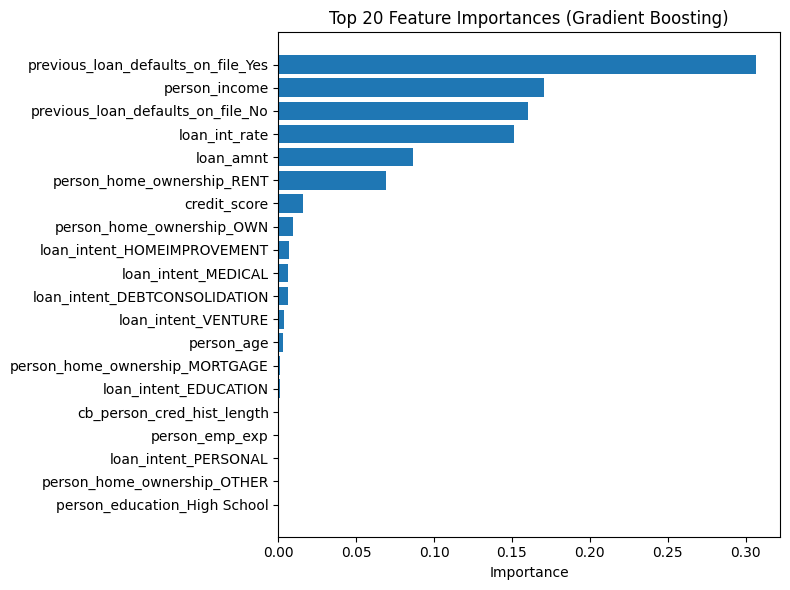

In [163]:
best_gb_pipe = search.best_estimator_

ohe = best_gb_pipe.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehotencoder']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, cat_names]

importances = best_gb_pipe.named_steps['gradientboostingclassifier'].feature_importances_

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1])
plt.title('Top 20 Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()